# Automatic assignment of genres from movie synopsis using supervised machine learning

## 1. Import libraries and load data

In [46]:
packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import json
from textblob import TextBlob, Word
import nltk
import re
import csv
import matplotlib.pyplot as plt 
#import seaborn as sns
#from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [64]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn import model_selection

In [64]:
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
# Performance metric
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

In [2]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## 2. DATA PREPARATION 

In [17]:
ps =PorterStemmer() # stemmer to lemmatize words
#function to remove all the stopwords that may affects the prestation of the model

nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# function for text cleaning 
def preprocess_text(text):
    text = text.lower() # lowercase
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text) #line breaks
    #text = re.sub(r"\'\xa0", " ", text) # xa0 Unicode representing spaces
    #text = re.sub('\s+', ' ', text) # one or more whitespace characters
    text = text.strip(' ') # spaces
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    #lemmatize and remove stopwords
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    text = ' '.join(no_stopword_text) 
        
    return text

train['clean_plot'] = train['synopsis'].apply(lambda x: preprocess_text(x))
test['clean_plot'] = test['synopsis'].apply(lambda x: preprocess_text(x))

In [40]:
def lemma(text): # Lemmatization of cleaned body
        sent = TextBlob(text)
        tag_dict = {"J": 'a', 
                    "N": 'n', 
                    "V": 'v', 
                    "R": 'r'}
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
        seperator=' '
        lemma = seperator.join(lemmatized_list) 
        return lemma

In [41]:
train['lemma'] = train['clean_plot'].apply(lambda x: lemma(x))
test['lemma'] = test['clean_plot'].apply(lambda x: lemma(x))
train.head()

,movie_id,year,synopsis,genres,clean_plot,lemma,lemmalist
0,30924,2005,Cruel But Necessary is the story of Betty Muns...,Drama,cruel necessary story betty munson strange jou...,cruel necessary story betty munson strange jou...,cruel necessary story betty munson strange jou...
1,34841,2012,"Yorkshire, 1974, the Maynard family moves into...",Drama Horror Thriller,yorkshire maynard family moves dream house dre...,yorkshire maynard family move dream house drea...,yorkshire maynard family move dream house drea...
2,23408,2017,When a renowned architecture scholar falls sud...,Drama,renowned architecture scholar falls suddenly i...,renowned architecture scholar fall suddenly il...,renowned architecture scholar fall suddenly il...
3,39470,1996,The story dealt with Lord Rama and his retalia...,Children Drama,story dealt lord rama retaliation ravana chara...,story dealt lord rama retaliation ravana chara...,story dealt lord rama retaliation ravana chara...
4,7108,2003,A Thai playboy cons a girl into bed and then l...,Comedy Drama Horror Thriller,thai playboy cons girl bed leaves finding preg...,thai playboy con girl bed leave find pregnant ...,thai playboy con girl bed leave find pregnant ...


## 3. Variables preparation 

In [42]:
#estrapolate the genres vector from the train dataset
X = train['lemma']
y = train['genres']
    

### 3.1 Target variable one hot encoding

In [49]:
#apply the onehot transformation for the genres vector

one_hot = MultiLabelBinarizer() # encoder for the  tags 
y_onehot = one_hot.fit_transform(y.str.split(' ')) 
y_bin = pd.DataFrame(y_onehot, columns=one_hot.classes_ ) # transform it to Pandas object

In [50]:
print(y_bin.shape)
y_bin.head()


(36518, 19)


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [53]:
tfidf_vectorizer = TfidfVectorizer(norm=None,analyzer='word',min_df = 5, max_df = 0.8, ngram_range=(1,2),max_features = 10000, use_idf=True)

In [54]:
# applying TF-IDF features to the synopsis
TF_IDF = tfidf_vectorizer.fit_transform(X)
TF_IDF_dense = TF_IDF.todense()

In [55]:
# 80/20 split TF-IDF
X_tfidf_train, X_tfidf_val, y_train_bin, y_val_bin = train_test_split(TF_IDF_dense, y_bin,  test_size=0.2,train_size=0.8, random_state=0)

## 4.The Model

In [62]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [70]:
def print_score(y_pred, clf):
    
    print("Clf: ", clf.__class__.__name__)
    print("Jaccard score: {}".format(jaccard_score(y_val_bin, y_pred, average='weighted'))) # measure of similarity for the two sets of data. Average is set to "samples" since is between two multilabeled
    print("Hamming loss: {}".format((hamming_loss(y_pred, y_val_bin)))) #% of the wrong labels to the total number of labels
    print("Accuracy score: {}".format((accuracy_score(y_val_bin, y_pred))))   
    print("---")    

In [80]:
lr = LogisticRegression(solver='lbfgs', max_iter=350)
sgd = SGDClassifier() # stochastic gradient descent (SGD) learning
mn = MultinomialNB() # naive Bayes algorithm for multinomially distributed data,
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier() # Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example.
dummy_clf = DummyClassifier(random_state=0, strategy="most_frequent")

classifiers_list = [dummy_clf,lr, pac, svc, mn, perceptron]
classifiers_jaccard_scores = []
classifiers_hamming_losses = []
classifiers_accuracy_scores = []

In [81]:
for classifier in classifiers_list:
    process_time_starts()
    
    clf = MultiOutputClassifier(classifier) # check sklearn
    print("fit running....")
    clf.fit(X_tfidf_train, y_train_bin)
    y_pred = clf.predict(X_tfidf_val)
    classifiers_jaccard_scores.append(jaccard_score(y_val_bin, y_pred, average='weighted'))
    classifiers_hamming_losses.append((hamming_loss(y_pred, y_val_bin)))
    classifiers_accuracy_scores.append(accuracy_score(y_val_bin, y_pred))

    
    print("time up")
    time_elapsed()
    print_score(y_pred, classifier)
    
    print("---")

fit running....
time up
The process took: 0hour:0min:0sec
Clf:  DummyClassifier
Jaccard score: 0.0
Hamming loss: 0.09881391595088487
Accuracy score: 0.0
---
---
fit running....


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


time up
The process took: 0hour:13min:26sec
Clf:  LogisticRegression
Jaccard score: 0.30729483907363847
Hamming loss: 0.10934167291174267
Accuracy score: 0.12664293537787513
---
---
fit running....
time up
The process took: 0hour:5min:50sec
Clf:  PassiveAggressiveClassifier
Jaccard score: 0.30093517814275883
Hamming loss: 0.11656194154608866
Accuracy score: 0.10980284775465499
---
---
fit running....


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge

time up
The process took: 0hour:0min:37sec
Clf:  LinearSVC
Jaccard score: 0.2917360901426217
Hamming loss: 0.12293912492073557
Accuracy score: 0.09583789704271632
---
---
fit running....
time up
The process took: 0hour:0min:10sec
Clf:  MultinomialNB
Jaccard score: 0.3804237624165627
Hamming loss: 0.12825704732806825
Accuracy score: 0.10651697699890471
---
---
fit running....
time up
The process took: 0hour:3min:47sec
Clf:  Perceptron
Jaccard score: 0.30143141351556996
Hamming loss: 0.11440739032685766
Accuracy score: 0.11527929901423878
---
---


In [86]:
#lr = LogisticRegression()
#clf = OneVsRestClassifier(lr)

classifiers_list =['Dummy Classifier', 'Logistic Regression', 'PassiveAggressiveClassifier','LinearSVC', 'Multinomial Naive Bayes', 'Perceptron']

df_clf = pd.DataFrame(classifiers_list, columns = ['classifiers'])
df_clf['Jaccard_score'] = classifiers_jaccard_scores
df_clf['Hamming_loss'] = classifiers_hamming_losses
df_clf['Accuracy'] = classifiers_accuracy_scores
df_clf = df_clf.sort_values(by=['Hamming_loss'])
best_classifier = df_clf.iloc[df_clf['Accuracy'].argmax(), 0]
print('The best classifier among those tested is: ',best_classifier)
df_clf

The best classifier among those tested is:  Logistic Regression


,classifiers,Jaccard_score,Hamming_loss,Accuracy
0,Dummy Classifier,0.000000,0.098814,0.000000
1,Logistic Regression,0.307295,0.109342,0.126643
5,Perceptron,0.301431,0.114407,0.115279
2,PassiveAggressiveClassifier,0.300935,0.116562,0.109803
3,LinearSVC,0.291736,0.122939,0.095838
4,Multinomial Naive Bayes,0.380424,0.128257,0.106517


[]

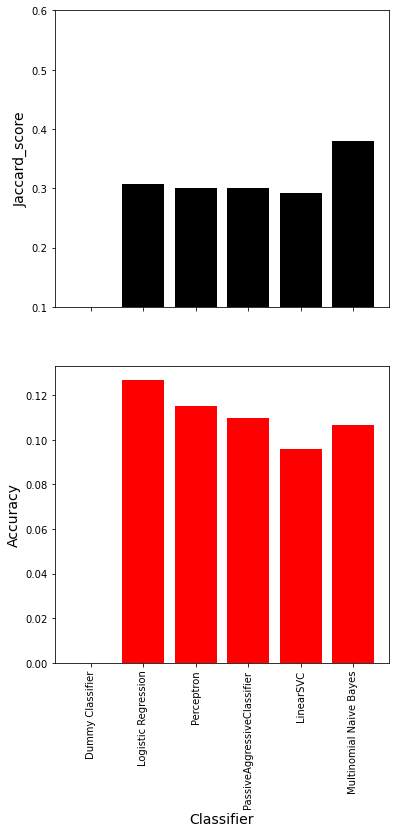

In [87]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
plt.bar(df_clf['classifiers'],df_clf['Jaccard_score'], color = 'k')
plt.ylabel('Jaccard_score',fontsize = 14)
plt.ylim((0.1, 0.6))   # set the ylim to bottom, top
plt.xticks(df_clf['classifiers']," ")

plt.subplot(212)

plt.bar(df_clf['classifiers'],df_clf['Accuracy'], color = 'r') 
plt.ylabel('Accuracy',fontsize = 14)
#plt.ylim((0.1, 0.3))
plt.xlabel('Classifier', fontsize = 14)
plt.xticks(rotation=90)
plt.plot()
# fit model on train data
#clf.fit(xtrain_tfidf,y)

## 5.The prediction

In [ ]:
y_pred = clf.predict(tfidf_vectorizer.transform(X_test))

In [ ]:
y_pred.shape

In [ ]:
print(len(multilabel_binarizer.inverse_transform(y_pred)))
pred_gen = multilabel_binarizer.inverse_transform(y_pred)

In [ ]:
submission = pd.DataFrame(data= {'movie_id':x_test.movie_id,'predicted_genres':pred_gen})

In [ ]:
for i in range(0,len(submission.predicted_genres)):
   submission.predicted_genres[i] =(','.join((submission.predicted_genres[i])))

In [ ]:
for i in range(0,len(submission.predicted_genres)):
    submission.predicted_genres[i] = submission.predicted_genres[i].replace(","," ")

In [ ]:
submission.to_csv('submission.csv',index=False)

the model does not predict the genres for all the movies, maybe should be a good idea implement a multiclass model instead of multilabel, another option could be change the model, using something else instead of Onevstherest classifier.